In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm import tqdm
import warnings
from keras.models import *
from keras.layers import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras import Model

In [15]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_height = 256
image_width = 256
image_depth = 1
epochs=50
batch_size = 32
epoch_index = [i for i in range(1, epochs+1)]

#### Load data

In [3]:
images = np.load(os.path.join("Brain_MRI_data1", "images.npy"), allow_pickle=True)
masks = np.load(os.path.join("Brain_MRI_data1", "masks.npy"), allow_pickle=True)

#### Change all image to grey

In [4]:
image_index = 0
for image in tqdm(images):
    plt.imsave(os.path.join("Brain_MRI_Segment_image", "image_{}.jpg".format(image_index)), image, cmap='gray')
    image_index += 1

mask_index = 0
for mask in tqdm(masks):
    plt.imsave(os.path.join("Brain_MRI_Segment_mask", "mask_{}.jpg".format(mask_index)), mask, cmap='gray')
    mask_index += 1

 10%|▉         | 303/3064 [00:02<00:24, 112.89it/s]


KeyboardInterrupt: 

In [3]:
image_dir_name = "Brain_MRI_Segment_image"
mask_dir_name = "Brain_MRI_Segment_mask"
image_list = list()
mask_list = list()

images_dir = sorted(os.listdir(image_dir_name))
for image in tqdm(images_dir):
    current_image = cv2.imread(os.path.join(image_dir_name, image), cv2.IMREAD_GRAYSCALE)
    current_image = cv2.resize(current_image, (image_height, image_width))
    current_image_180 = cv2.rotate(current_image, cv2.ROTATE_180)
    current_image_r90 = cv2.rotate(current_image, cv2.ROTATE_90_CLOCKWISE)
    current_image_l90 = cv2.rotate(current_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    image_list.append(current_image)
    image_list.append(current_image_180)
    image_list.append(current_image_r90)
    image_list.append(current_image_l90)



masks_dir = sorted(os.listdir(mask_dir_name))
for mask in tqdm(masks_dir):
    current_mask = cv2.imread(os.path.join(mask_dir_name, mask), cv2.IMREAD_GRAYSCALE)
    current_mask = cv2.resize(current_mask, (image_height, image_width))
    current_mask_180 = cv2.rotate(current_mask, cv2.ROTATE_180)
    current_mask_r90 = cv2.rotate(current_mask, cv2.ROTATE_90_CLOCKWISE)
    current_mask_l90 = cv2.rotate(current_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
    mask_list.append(current_mask)
    mask_list.append(current_mask_180)
    mask_list.append(current_mask_r90)
    mask_list.append(current_mask_l90)


features = np.array(image_list)/255.0
masks = np.array(mask_list)/255.0
features = features.reshape((features.shape[0], features.shape[1], features.shape[2], 1))
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

100%|██████████| 3064/3064 [00:02<00:00, 1395.99it/s]


In [4]:
print("image dimension: {}, label dimension: {}".format(features.shape, masks.shape))

image dimension: (12256, 256, 256, 1), label dimension: (12256, 256, 256, 1)


#### Train, Test, Validation Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, masks, test_size=0.25, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype("float32")

In [6]:
# Save model function
def save_model(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                                    monitor='val_binary_accuracy',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='max')
    return [checkpoint]

#### Define U-Net Model and Loss Function

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2 * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [8]:
unet_path = "unet.hdf5"
model_Unet = unet(input_size=(image_height,image_width,1))
model_Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
model_Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
unet_history = model_Unet.fit(x=X_train,y=y_train, epochs=50, verbose=1,
                        validation_data=(X_val, y_val), callbacks=save_model(unet_path))

Epoch 1/50
216/216 [==============================] - 55s 194ms/step - loss: -0.0335 - dice_coef: 0.0335 - binary_accuracy: 0.3437 - val_loss: -0.0343 - val_dice_coef: 0.0343 - val_binary_accuracy: 0.4381

Epoch 00001: val_binary_accuracy improved from -inf to 0.43811, saving model to trained_model_weights\unet.hdf5
Epoch 2/50
216/216 [==============================] - 37s 172ms/step - loss: -0.0991 - dice_coef: 0.0993 - binary_accuracy: 0.6870 - val_loss: -0.2406 - val_dice_coef: 0.2406 - val_binary_accuracy: 0.9722

Epoch 00002: val_binary_accuracy improved from 0.43811 to 0.97224, saving model to trained_model_weights\unet.hdf5
Epoch 3/50
216/216 [==============================] - 37s 174ms/step - loss: -0.2718 - dice_coef: 0.2720 - binary_accuracy: 0.9729 - val_loss: -0.2927 - val_dice_coef: 0.2927 - val_binary_accuracy: 0.9711

Epoch 00003: val_binary_accuracy did not improve from 0.97224
Epoch 4/50
216/216 [==============================] - 38s 174ms/step - loss: -0.3230 - dice_c

Text(0.5, 1.0, 'Unet for segmentation')

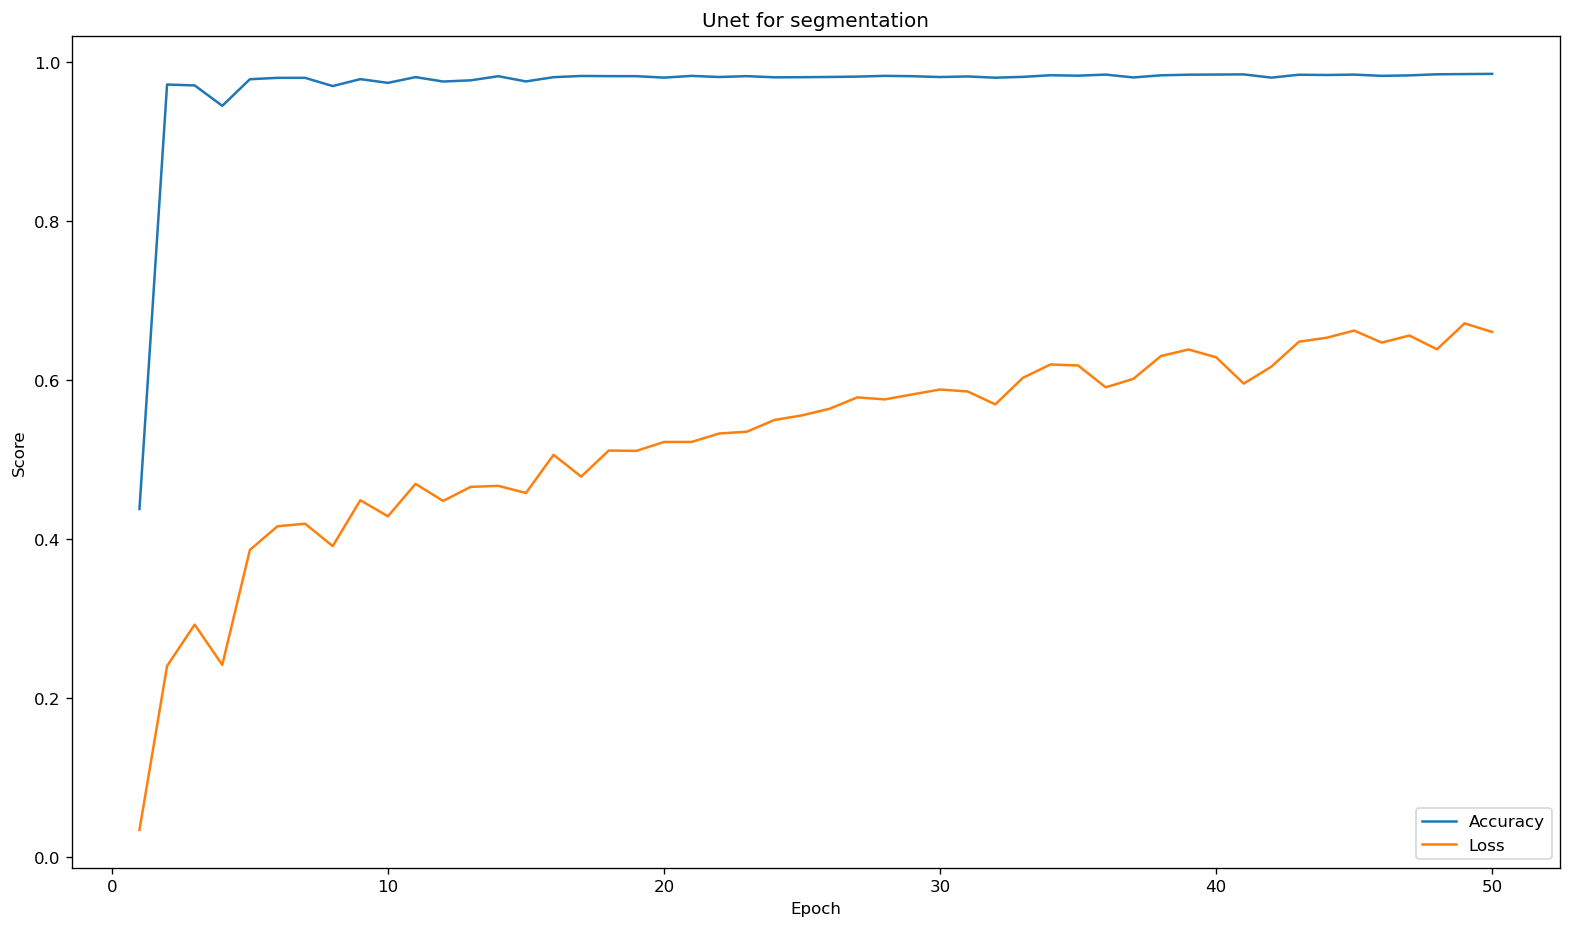

In [16]:
model_Unet_result = pd.DataFrame({"Accuracy": unet_history.history["val_binary_accuracy"],
                                  "Loss": unet_history.history["val_dice_coef"]}, index=epoch_index)
model_Unet_result.to_csv("Unet_result.csv")
ax_unet = model_Unet_result.plot.line(figsize=(16, 9))
ax_unet.set_xlabel("Epoch")
ax_unet.set_ylabel("Score")
ax_unet.set_title("Unet for segmentation")

In [13]:
model_Unet.load_weights(os.path.join("trained_model_weights", unet_path))
model_Unet.evaluate(x=X_test, y=y_test)

96/96 [==============================] - 8s 79ms/step - loss: -0.6552 - dice_coef: 0.6552 - binary_accuracy: 0.9851


[-0.6551928520202637, 0.6551888585090637, 0.9851043224334717]